In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
imsize = 512 if use_cuda else 128
transform = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def load_image(image_name):
    im = Image.open('data/style_transfer/%s' % image_name)
    im = Variable(transform(im))
    im = im.unsqueeze(0)
    return im

style_img =  load_image('picasso.jpg').type(dtype)
content_img = load_image('dancing.jpg').type(dtype)

print(style_img.size(), content_img.size())

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


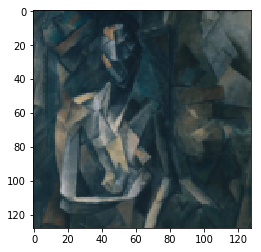

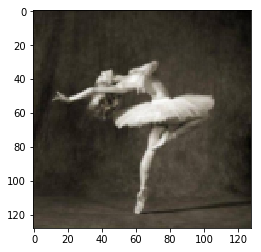

In [4]:
revert = transforms.ToPILImage()

def imshow(tensor):
    image = tensor.clone().cpu()
    image = image.squeeze(0)
    image = revert(image)
    plt.imshow(image)

plt.figure()
imshow(style_img.data)

plt.figure()
imshow(content_img.data)

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, k, m, n = input.size()
        features = input.view(b*k, m*n)     
        gram = torch.mm(features, features.t())
        return gram.div(b*k*m*n)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        self.gram = GramMatrix()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [8]:
import torchvision.models as models

In [9]:
cnn = models.vgg19(pretrained=True).features
if use_cuda:
    cnn = cnn.cuda()

In [10]:
import copy

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_model_and_losses(cnn, content_img, style_img, content_weight=1000, style_weight=1, 
                         content_layers=content_layers_default, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    content_losses, style_losses = [], []
    
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
        
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss_' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
            
            i += 1
        
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + str(i)
            model.add_module(name, layer)
    
    return model, content_losses, style_losses

In [12]:
import torch.optim as optim

def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    input_optim = optim.LBFGS([input_param])
    return input_param, input_optim

In [13]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300, 
                       content_weight=1, style_weight=1000):
    model, content_losses, style_losses = get_model_and_losses(cnn, content_img, style_img, 
                                                               content_weight=content_weight, 
                                                               style_weight=style_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    i = 0
    while i < num_steps:
        def closure():
            nonlocal i
            input_param.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_param)
            content_score, style_score = 0, 0
            
            for c in content_losses:
                content_score += c.backward()
            for s in style_losses:
                style_score += s.backward()
            
            i += 1
            if i % 50 == 0:
                print('run {}:'.format(i))
                print('Style Loss: {:4f}, Content Loss: {:4f}'.format(content_score.data[0], style_score.data[0]))
            
            return content_score + style_score
        
        optimizer.step(closure)
    
    input_param.data.clamp_(0, 1)
    return input_param.data

/home/wilsonyan/miniconda3/envs/py3/lib/python3.6/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


run 50:
Style Loss: 1.387822, Content Loss: 2.587850
run 100:
Style Loss: 1.276546, Content Loss: 0.608227
run 150:
Style Loss: 1.162017, Content Loss: 0.434450
run 200:
Style Loss: 1.121905, Content Loss: 0.358105
run 250:
Style Loss: 1.096352, Content Loss: 0.322412
run 300:
Style Loss: 1.079032, Content Loss: 0.304358


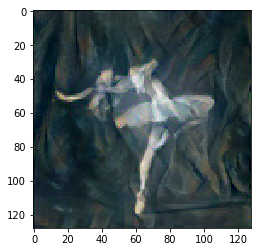

In [15]:
input_img = content_img.clone()
output = run_style_transfer(cnn, content_img, style_img, input_img, style_weight=2000)

plt.figure()
imshow(output)